# HDDA F24 Recommendation systems via approximate matrix factorization

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 1


In [424]:
import copy
import math
from typing import Callable, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import torch
import time
import tqdm
from scipy.sparse import csr_matrix
from sklearn.impute import SimpleImputer

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

## Utilities


In [425]:
def get_params_combinations(params: list[list]):
    if len(params) == 0:
        return [[]]
    return [(x, *k) for k in get_params_combinations(params[1:]) for x in params[0]]


def get_params_combinations_dict(
    possible_params_dict: dict[str, list]
) -> list[tuple[dict, str]]:
    if len(possible_params_dict) == 0:
        return [({}, "")]
    dict_items = list(possible_params_dict.items())

    first_item = dict_items[0]

    if not isinstance(first_item[1], list):
        return [
            ({first_item[0]: first_item[1], **k}, name)
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
        ]

    if (
        len(first_item[1]) > 0
        and isinstance(first_item[1][0], tuple)
        and isinstance(first_item[1][0][0], str)
    ):
        return [
            (
                {first_item[0]: x, **k},
                f"{first_item[0]}=[{x_name}]{', ' + name if len(name) > 0 else ''}",
            )
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
            for x_name, x in first_item[1]
        ]

    if (
        len(first_item[1]) > 0 and str(first_item[1][0]) != "<"  # has ___str__
    ):
        return [
            (
                {first_item[0]: x, **k},
                f"{first_item[0]}=[{x!s}]{', ' + name if len(name) > 0 else ''}",
            )
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
            for x in first_item[1]
        ]

    return [
        (
            {first_item[0]: x, **k},
            f"{first_item[0]}=[{x}]{', ' + name if len(name) > 0 else ''}",
        )
        for k, name in get_params_combinations_dict(dict(dict_items[1:]))
        for x in first_item[1]
    ]

In [426]:
def rmse_score(
    initial_matrix: torch.Tensor, predicted_matrix: torch.Tensor, test_mask: torch.Tensor
) -> float:
    differences = (initial_matrix[test_mask] - predicted_matrix[test_mask]) ** 2
    return torch.sqrt(differences.mean()).item()


def predict_matrix(u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    return torch.clip(u @ v, 1, 5)

In [427]:
def choose_best(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    solver: Callable,
    possible_params: dict,
) -> tuple[torch.Tensor, float, int, float, str, dict]:
    matrix = matrix.to(DEVICE)
    mask = mask.to(DEVICE)
    test_mask = test_mask.to(DEVICE)

    best_loss = 1e3
    best_time = 1e3
    best_solution = torch.zeros(1)
    best_iter = 0
    best_name = ""

    log_dicts = {}

    for params, name in get_params_combinations_dict(possible_params):
        log_dict = solver(matrix, mask, test_mask, **params)
        log_dicts[name] = log_dict

        loss = log_dict["best_rmse_test"]
        total_time = log_dict["best_time"]

        if loss < best_loss or (loss == best_loss and total_time < best_time):
            best_loss = loss
            best_time = total_time
            best_iter = log_dict["best_k"]
            best_name = name
            best_u = log_dict["best_u"].to(DEVICE)
            best_v = log_dict["best_v"].to(DEVICE)

    best_solution = matrix + (~mask) * predict_matrix(best_u, best_v)
    return best_solution, best_loss, best_iter, best_time, best_name, log_dicts

In [428]:
def plot_log_dicts(
    log_dicts: dict,
    title: str,
    row_plots: int = 2,
    plot_width: float = 8,
    plot_height: float = 4,
):
    num_plots = 8
    row_plots = min(row_plots, num_plots)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )
    axs_list = list(axs.flat)

    for ax in axs_list:
        ax.grid()

    axs_list[0].set(xlabel="Iteration", ylabel="RMSE, log")
    axs_list[1].set(xlabel="Time, seconds", ylabel="RMSE, log")
    axs_list[2].set(xlabel="Iteration", ylabel="Objective, log")
    axs_list[3].set(xlabel="Time, seconds", ylabel="Objective, log")
    axs_list[4].set(xlabel="Iteration", ylabel="RMSE on test, log")
    axs_list[5].set(xlabel="Time, seconds", ylabel="RMSE on test, log")
    axs_list[6].set(xlabel="Iteration", ylabel="Objective on test, log")
    axs_list[7].set(xlabel="Time, seconds", ylabel="Objective on test, log")

    for i, ax in enumerate(axs_list):
        if i < 4:
            ax.set_title("Results on train data")
            continue
        ax.set_title("Results on test data")

    for ax in axs_list:
        ax.set_yscale("log")

    for name, log_dict in log_dicts.items():
        for i, label in [(0, "iteration"), (1, "time")]:
            axs_list[0 + i].plot(log_dict[label], log_dict["rmse"], label=name)
            axs_list[2 + i].plot(log_dict[label], log_dict["objective"], label=name)
            axs_list[4 + i].plot(log_dict[label], log_dict["rmse_test"], label=name)
            axs_list[6 + i].plot(log_dict[label], log_dict["objective_test"], label=name)

    fig.suptitle(title, fontsize=14)

    lines_labels = [axs_list[0].get_legend_handles_labels()]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]

    max_in_row = 3
    fig.legend(
        lines,
        labels,
        loc="outside lower center",
        ncol=min(max_in_row, len(log_dicts)),
        bbox_to_anchor=(0.5, -0.05 * math.ceil(len(log_dicts) / max_in_row)),
    )

    plt.tight_layout(w_pad=5)
    plt.show()

In [429]:
def train_test_split_matrix(
    matrix: np.ndarray, mask: np.ndarray, test_percent: float, seed=420
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    np.random.seed(seed)

    train_matrix = matrix.copy().flatten()
    train_mask = mask.copy().flatten()
    test_mask = np.zeros(mask.shape).astype(bool).flatten()

    existing_indices = np.argsort(~train_mask)[: np.sum(train_mask)]
    test_indices = np.random.choice(
        existing_indices, int(existing_indices.shape[0] * test_percent), replace=False
    )

    train_matrix[test_indices] = 0.0
    train_mask[test_indices] = False
    test_mask[test_indices] = True

    matrix_shape = matrix.shape

    return torch.tensor(train_matrix.reshape(matrix_shape)).float().to(
        DEVICE
    ), torch.tensor(train_mask.reshape(matrix_shape)).bool().to(DEVICE), torch.tensor(
        test_mask.reshape(matrix_shape)
    ).bool().to(DEVICE), torch.tensor(matrix).float().to(DEVICE), torch.tensor(
        mask
    ).bool().to(DEVICE)

## Data loading


### Toy data


In [430]:
toy_matrix_full = np.array(
    [
        [2, 3, 2, 0, 0],
        [0, 2, 0, 4, 3],
        [3, 0, 3, 0, 4],
        [0, 3, 0, 4, 3],
        [0, 0, 0, 0, 2],
        [1, 4, 3, 4, 0],
    ]
)

toy_mask_full = toy_matrix_full != 0

In [431]:
toy_mask_full

array([[ True,  True,  True, False, False],
       [False,  True, False,  True,  True],
       [ True, False,  True, False,  True],
       [False,  True, False,  True,  True],
       [False, False, False, False,  True],
       [ True,  True,  True,  True, False]])

In [432]:
(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    toy_matrix_full,
    toy_mask_full,
) = train_test_split_matrix(toy_matrix_full, toy_mask_full, test_percent=0.2)

### Real data


In [433]:
def load_real_data() -> tuple[np.ndarray, np.ndarray]:
    data = scipy.io.loadmat("./data/Data/matlab/inputX.mat")
    x = csr_matrix(data["X"]).toarray()
    mask = x != 0
    return x, mask


real_matrix_full, real_mask_full = load_real_data()

In [434]:
(
    real_matrix,
    real_mask,
    real_test_mask,
    real_matrix_full,
    real_mask_full,
) = train_test_split_matrix(real_matrix_full, real_mask_full, test_percent=0.2)

print(f"Test size: {int(real_test_mask.sum())}")

Test size: 160033


## Test real data


In [435]:
def load_real_test_flatten_indices(real_matrix_shape: tuple) -> torch.Tensor:
    data = scipy.io.loadmat("./data/Data/matlab/inputEval.mat")
    x = data["Eval"]
    rows_indices = x[:, 0].astype(np.float64) - 1
    columns_indices = x[:, 1].astype(np.float64) - 1
    return (
        torch.tensor(rows_indices * real_matrix_shape[1] + columns_indices)
        .int()
        .to(DEVICE)
    )


real_test_flatten_indices = load_real_test_flatten_indices(real_matrix.shape)
real_test_flatten_indices

tensor([     593,     3104,     1544,  ..., 23868889, 23868137, 23868149],
       device='cuda:0', dtype=torch.int32)

In [436]:
def save_solution(
    matrix: torch.Tensor,
    test_flatten_indices: torch.Tensor = real_test_flatten_indices,
    prefix: str = "",
    decimals: int = 4,
):
    predictions = np.round(
        matrix.flatten()[test_flatten_indices].cpu().numpy(), decimals=decimals
    )
    results = pd.DataFrame(
        predictions, columns=["Rating"], index=np.arange(1, predictions.shape[0] + 1)
    )
    results.to_csv(f"./solutions/{prefix}submission.csv", index_label="ID")

## Boosters


### LR strategies


In [437]:
class LearningRateScheduler:
    @staticmethod
    def _vector_dot(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return x.dot(y)

    @staticmethod
    def _matrix_dot(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.trace(x.T @ y)

    def __init__(self, assume_vectors: bool = False) -> None:
        self.set_assume_vectors(assume_vectors)
        self.reset()

    def reset(self) -> None:
        pass

    def set_assume_vectors(self, assume_vectors: bool):
        self.assume_vectors = assume_vectors
        self.dot = (
            LearningRateScheduler._vector_dot
            if self.assume_vectors
            else LearningRateScheduler._matrix_dot
        )

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        raise NotImplementedError


class Normal(LearningRateScheduler):
    def __init__(
        self,
        lr: Callable[[int], float] | float = 1e-3,
        name: str = "",
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.name = name
        self.lr = lr
        self.lr_func: Callable[[int], float] = (
            (lambda _: lr) if isinstance(lr, float) else lr
        )  # type: ignore

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        return self.lr_func(k)

    def __str__(self) -> str:
        return (
            self.name
            if self.name
            else (str(self.lr) if isinstance(self.lr, float) else "normal")
        )


class Estimate1OverL(LearningRateScheduler):
    def __init__(
        self,
        beta: float = 0.5,
        max_iters: int = 100,
        eps: float = 1e-7,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.beta = beta
        self.max_iters = max_iters
        self.eps = eps

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = 1
        d_norm = torch.norm(direction)

        for _ in range(self.max_iters):
            x_next = x + alpha * direction
            if torch.norm(grad - grad_f(x_next)) > torch.norm(d_norm):
                alpha *= self.beta
                if alpha < 1e-10:
                    return alpha

            else:
                return alpha

        return alpha

    def __str__(self) -> str:
        return "1/L"


class AdaptiveStep(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1e-6,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step

    def reset(self) -> None:
        self.theta = np.inf
        self.prev_step = None

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        if self.prev_step is None:
            step = self.start_step
            self.theta = np.inf
            self.prev_step = step
            return step

        step = self.prev_step
        if torch.norm(prev_grad - grad) < 1e-5:
            min_value = np.sqrt(1 + self.theta) * step
        else:
            min_value = min(
                np.sqrt(1 + self.theta) * step,
                float(
                    (torch.norm(x - prev_x) / (2 * torch.norm(prev_grad - grad)))
                    .cpu()
                    .numpy(),
                ),
            )
        if min_value == np.inf:
            min_value = 0.001

        self.theta = min_value / step
        step = min_value
        self.prev_step = step

        return step

    def __str__(self) -> str:
        return "adaptive"


class Armijo(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1,
        c1: float = 1e-6,
        beta: float = 0.5,
        max_iters: int = 100,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.c1 = c1
        self.beta = beta
        self.max_iters = max_iters

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = self.start_step

        d_g = self.dot(grad, direction).item()
        f_x = f(x)

        i = 0
        while f(x + alpha * direction) > f_x + self.c1 * alpha * d_g:
            i += 1

            if i == self.max_iters:
                return alpha

            if alpha < 1e-7:
                return alpha

            alpha = alpha * self.beta

        return alpha

    def __str__(self) -> str:
        return "armijo"


class StrongWolfe(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1,
        c1: float = 1e-4,
        c2: float = 0.9,
        beta: float = 0.5,
        max_iters: int = 50,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.c1 = c1
        self.c2 = c2
        self.beta = beta
        self.max_iters = max_iters

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = self.start_step
        d_g = self.dot(grad, direction)
        abs_d_g = torch.abs(d_g)
        f_x = f(x)

        for _ in range(self.max_iters):
            if alpha < 1e-7:
                return alpha

            x_new = x + alpha * direction

            armijo_condition = f(x_new) > f_x + self.c1 * alpha * d_g
            curvature_condition = (
                torch.abs(self.dot(grad_f(x_new), direction)) > self.c2 * abs_d_g
            )
            if armijo_condition or curvature_condition:
                alpha *= self.beta
                continue
            return alpha
        return alpha

    def __str__(self) -> str:
        return "strong_wolfe"


class BisectionWolfe(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1,
        c1: float = 1e-5,
        c2: float = 0.9,
        beta: float = 0.5,
        max_iters: int = 100,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.c1 = c1
        self.c2 = c2
        self.beta = beta
        self.max_iters = max_iters

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = self.start_step
        lb = 0
        ub = np.inf
        d_g = self.dot(grad, direction)
        f_x = f(x)

        for _ in range(self.max_iters):
            if alpha < 1e-16:
                return alpha
            if f(x + alpha * direction) > f_x + self.c1 * alpha * d_g:
                ub = alpha
                alpha = 0.5 * (lb + ub)
            elif self.dot(grad_f(x + alpha * direction), direction) < self.c2 * d_g:
                lb = alpha
                alpha = 2 * lb if np.isinf(ub) else 0.5 * (lb + ub)
            else:
                return alpha
        return alpha

    def __str__(self) -> str:
        return "bisection_wolfe"

### Optimizers


In [438]:
class Optimizer:
    def __init__(self, lr_scheduler: LearningRateScheduler) -> None:
        self.lr_scheduler = lr_scheduler
        self.reset()

    def reset(self) -> None:
        self.prev_grad = torch.zeros(1)
        self.prev_x = torch.zeros(1)
        self.lr_scheduler.reset()

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        raise NotImplementedError


class GradientDescent(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        beta: float = 0.0,
        nesterov: bool = False,
    ) -> None:
        super().__init__(lr_scheduler)
        self.beta = beta
        self.nesterov = nesterov

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        if self.beta > 0:
            self.h = grad.clone() if k == 1 else (self.beta * self.h_prev + grad)

            if self.nesterov:
                direction = -(grad + self.beta * self.h)
            else:
                direction = -self.h
            self.h_prev = self.h.clone()
        else:
            direction = -grad.clone()

        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        name = "GD"
        if self.beta:
            name = f"{'Nesterov' if self.nesterov else 'HB'} b={self.beta}"
        return f"{name} lr={self.lr_scheduler!s}"


class AdaGrad(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        eps=1e-10,
        lr_decay: float = 0,
    ) -> None:
        super().__init__(lr_scheduler)

        self.lr_decay = lr_decay
        self.eps = eps

    def reset(self) -> None:
        super().reset()
        self.state_sum = None

    def get_direction(self, x: torch.Tensor, grad: torch.Tensor, k: int) -> torch.Tensor:
        if self.state_sum is None:
            state_sum = torch.zeros_like(grad)
        else:
            state_sum = self.state_sum.clone()
        state_sum += grad**2

        return -grad / torch.sqrt(state_sum + self.eps)

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        if self.state_sum is None:
            self.state_sum = torch.zeros_like(grad)

        self.state_sum += grad**2

        direction = -grad / torch.sqrt(self.state_sum + self.eps)
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )
        gamma = lr / (1 + k * self.lr_decay)

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + gamma * direction

    def __str__(self) -> str:
        return f"AdaGrad lr={self.lr_scheduler!s} lr_decay={self.lr_decay}"


class RMSprop(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        eps=1e-10,
        alpha=0.99,
    ) -> None:
        super().__init__(lr_scheduler)

        self.alpha = alpha
        self.eps = eps

    def reset(self) -> None:
        super().reset()
        self.exp_avg_sq = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        if self.exp_avg_sq is None:
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg_sq.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)

        direction = -grad / torch.sqrt(self.exp_avg_sq + self.eps)
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        return f"RMSprop lr={self.lr_scheduler!s} a={self.alpha}"


class Adam(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        betas: tuple[float, float] = (0.9, 0.999),
        eps=1e-10,
        weight_decay: float = 1e-2,
    ) -> None:
        super().__init__(lr_scheduler)

        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def reset(self) -> None:
        super().reset()
        self.exp_avg = None
        self.exp_avg_sq = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        beta1, beta2 = self.betas
        if self.exp_avg is None or self.exp_avg_sq is None:
            self.exp_avg = torch.zeros_like(x)
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        self.exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

        bias_correction1 = 1 - beta1**k
        bias_correction2 = 1 - beta2**k

        denom = self.exp_avg_sq.div(bias_correction2).sqrt_().add_(self.eps)

        direction = -(
            torch.div(self.exp_avg, bias_correction1).div_(denom) + self.weight_decay * x
        )
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        return f"Adam lr={self.lr_scheduler!s} b1={self.betas[0]} b2={self.betas[0]} w={self.weight_decay}"

In [439]:
class BFGS(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler = StrongWolfe(assume_vectors=True),
    ) -> None:
        super().__init__(lr_scheduler)

    def reset(self) -> None:
        super().reset()
        self.h = None
        self.identity = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        if not self.lr_scheduler.assume_vectors:
            raise BaseException("Vectors required")

        grad = grad_f(x)

        if self.h is None:
            self.h = torch.eye(x.shape[0]).to(x.device)
            self.identity = self.h.clone()

        direction = -(self.h @ grad)
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        if lr:
            x_new = x + lr * direction

            # Update H
            s = x_new - x
            y = grad_f(x_new) - grad

            r = 1 / (torch.dot(y, s) + 1e-10)
            ss = torch.outer(s, s)

            self.h = (
                self.h
                + r**2 * (torch.dot(y, s) + torch.dot(y, self.h @ y)) * ss
                - r * (self.h @ torch.outer(y, s) + torch.outer(s, y) @ self.h)
            )
        else:
            x_new = x - 1e-5 * grad

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x_new

    def __str__(self) -> str:
        return f"BFGS lr={self.lr_scheduler!s}"

### Other


In [440]:
class Logger:
    def __init__(
        self,
        matrix: torch.Tensor,
        mask: torch.Tensor,
        test_mask: torch.Tensor,
        f: Callable,
        f_params: dict = {},
        verbose: bool = True,
    ) -> None:
        self.matrix = matrix
        self.mask = mask
        self.test_mask = test_mask
        self.f = f
        self.f_params = f_params

        self.start_time = time.time()
        self._log_dict = {
            "objective": [],
            "objective_test": [],
            "rmse": [],
            "rmse_test": [],
            "time": [],
            "iteration": [],
            # Best part
            "best_rmse_test": 1e10,
            "best_k": 0,
            "best_time": 0,
            "best_u": torch.ones(1),
            "best_v": torch.ones(1),
        }
        self.verbose = verbose

    def log(
        self, u: torch.Tensor, v: torch.Tensor, k: int, loop: Optional[tqdm.tqdm] = None
    ):
        torch.cuda.current_stream().synchronize()

        objective = self.f(self.matrix, self.mask, u, v, **self.f_params)
        objective_test = self.f(self.matrix, self.test_mask, u, v, **self.f_params)

        rmse_sc = rmse_score(self.matrix, predict_matrix(u, v), self.mask)
        rmse_sc_test = rmse_score(self.matrix, predict_matrix(u, v), self.test_mask)
        if k == 0:
            self.start_time = time.time()
            end_time = 0
        else:
            end_time = time.time() - self.start_time
        self._log_dict["objective"].append(objective)
        self._log_dict["objective_test"].append(objective_test)
        self._log_dict["rmse"].append(rmse_sc)
        self._log_dict["rmse_test"].append(rmse_sc_test)
        self._log_dict["time"].append(end_time)
        self._log_dict["iteration"].append(k)
        if self.verbose and loop:
            loop.set_postfix(
                {
                    "Objective": objective,
                    "RMSE": rmse_sc,
                    "Objective[test]": objective_test,
                    "RMSE[test]": rmse_sc_test,
                }
            )

        # Update best
        if rmse_sc_test < self._log_dict["best_rmse_test"]:
            self._log_dict["best_rmse_test"] = rmse_sc_test
            self._log_dict["best_k"] = k
            self._log_dict["best_time"] = end_time
            self._log_dict["best_u"] = u.clone()
            self._log_dict["best_v"] = v.clone()

    @property
    def log_dict(self) -> dict:
        return self._log_dict

## Gradient Descent


### Train


In [441]:
def init_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    rank: int,
    strategy: Literal["random", "svd"],
    device: torch.device,
) -> tuple[torch.Tensor, torch.Tensor]:
    m, n = matrix.shape
    new_matrix = (mask * matrix).cpu().numpy()

    if strategy == "random":
        return torch.rand(m, rank).to(device), torch.rand(rank, n).to(device)

    if strategy == "svd":
        new_matrix = SimpleImputer(
            strategy="mean", missing_values=0, keep_empty_features=True
        ).fit_transform(new_matrix)

    u, s, vt = sklearn.utils.extmath.randomized_svd(  # type: ignore
        new_matrix, n_iter=25, n_components=rank
    )

    return torch.tensor(u).float().to(device), torch.tensor(vt).float().to(device)


def objective_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    u: torch.Tensor,
    v: torch.Tensor,
    regularization: float = 0.0,
) -> float:
    return (
        torch.norm(mask * torch.pow((matrix - (u @ v)), 2), p="fro")
        + regularization * (torch.norm(u, p="fro") ** 2 + torch.norm(v, p="fro") ** 2)
    ).item()


def nabla_objective_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    u: torch.Tensor,
    v: torch.Tensor,
    for_v: bool = False,
    regularization: float = 0.0,
) -> torch.Tensor:
    if for_v:
        return (
            -2 * u.T @ (mask * matrix)
            + 2 * u.T @ (mask * (u @ v))
            + regularization * 2 * v
        )

    return (
        -2 * (mask * matrix) @ v.T + 2 * (mask * (u @ v)) @ v.T + regularization * 2 * u
    )


def pure_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    rank: int | float,
    iterations: int,
    optimizer: Optimizer,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    verbose: bool = True,
    seed: int = 420,
    device: torch.device = DEVICE,
) -> dict:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    matrix = matrix.to(device)
    mask = mask.to(device)
    test_mask = test_mask.to(device)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy, device=device)
    optimizer.reset()
    u_optim = optimizer
    v_optim = copy.deepcopy(optimizer)

    # Initial log
    logger = Logger(
        matrix,
        mask,
        test_mask,
        objective_gd,
        f_params={"regularization": 0},
        verbose=verbose,
    )
    logger.log(u, v, 0)

    with tqdm.tqdm(range(1, iterations + 1), disable=not verbose) as loop:
        for k in loop:
            # Optimize
            u = u_optim.step(
                u,
                lambda x: objective_gd(matrix, mask, x, v, regularization=regularization),
                lambda x: nabla_objective_gd(
                    matrix, mask, x, v, regularization=regularization
                ),
                k,
            )

            v = v_optim.step(
                v,
                lambda x: objective_gd(matrix, mask, u, x, regularization=regularization),
                lambda x: nabla_objective_gd(
                    matrix, mask, u, x, for_v=True, regularization=regularization
                ),
                k,
            )

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            logger.log(u, v, k, loop=loop)

        return logger.log_dict

  0%|          | 0/10 [00:00<?, ?it/s, Objective=31, RMSE=2.07, Objective[test]=18.6, RMSE[test]=2.38]  

100%|██████████| 10/10 [00:00<00:00, 27.78it/s, Objective=1.67, RMSE=0.514, Objective[test]=2.05, RMSE[test]=0.893]


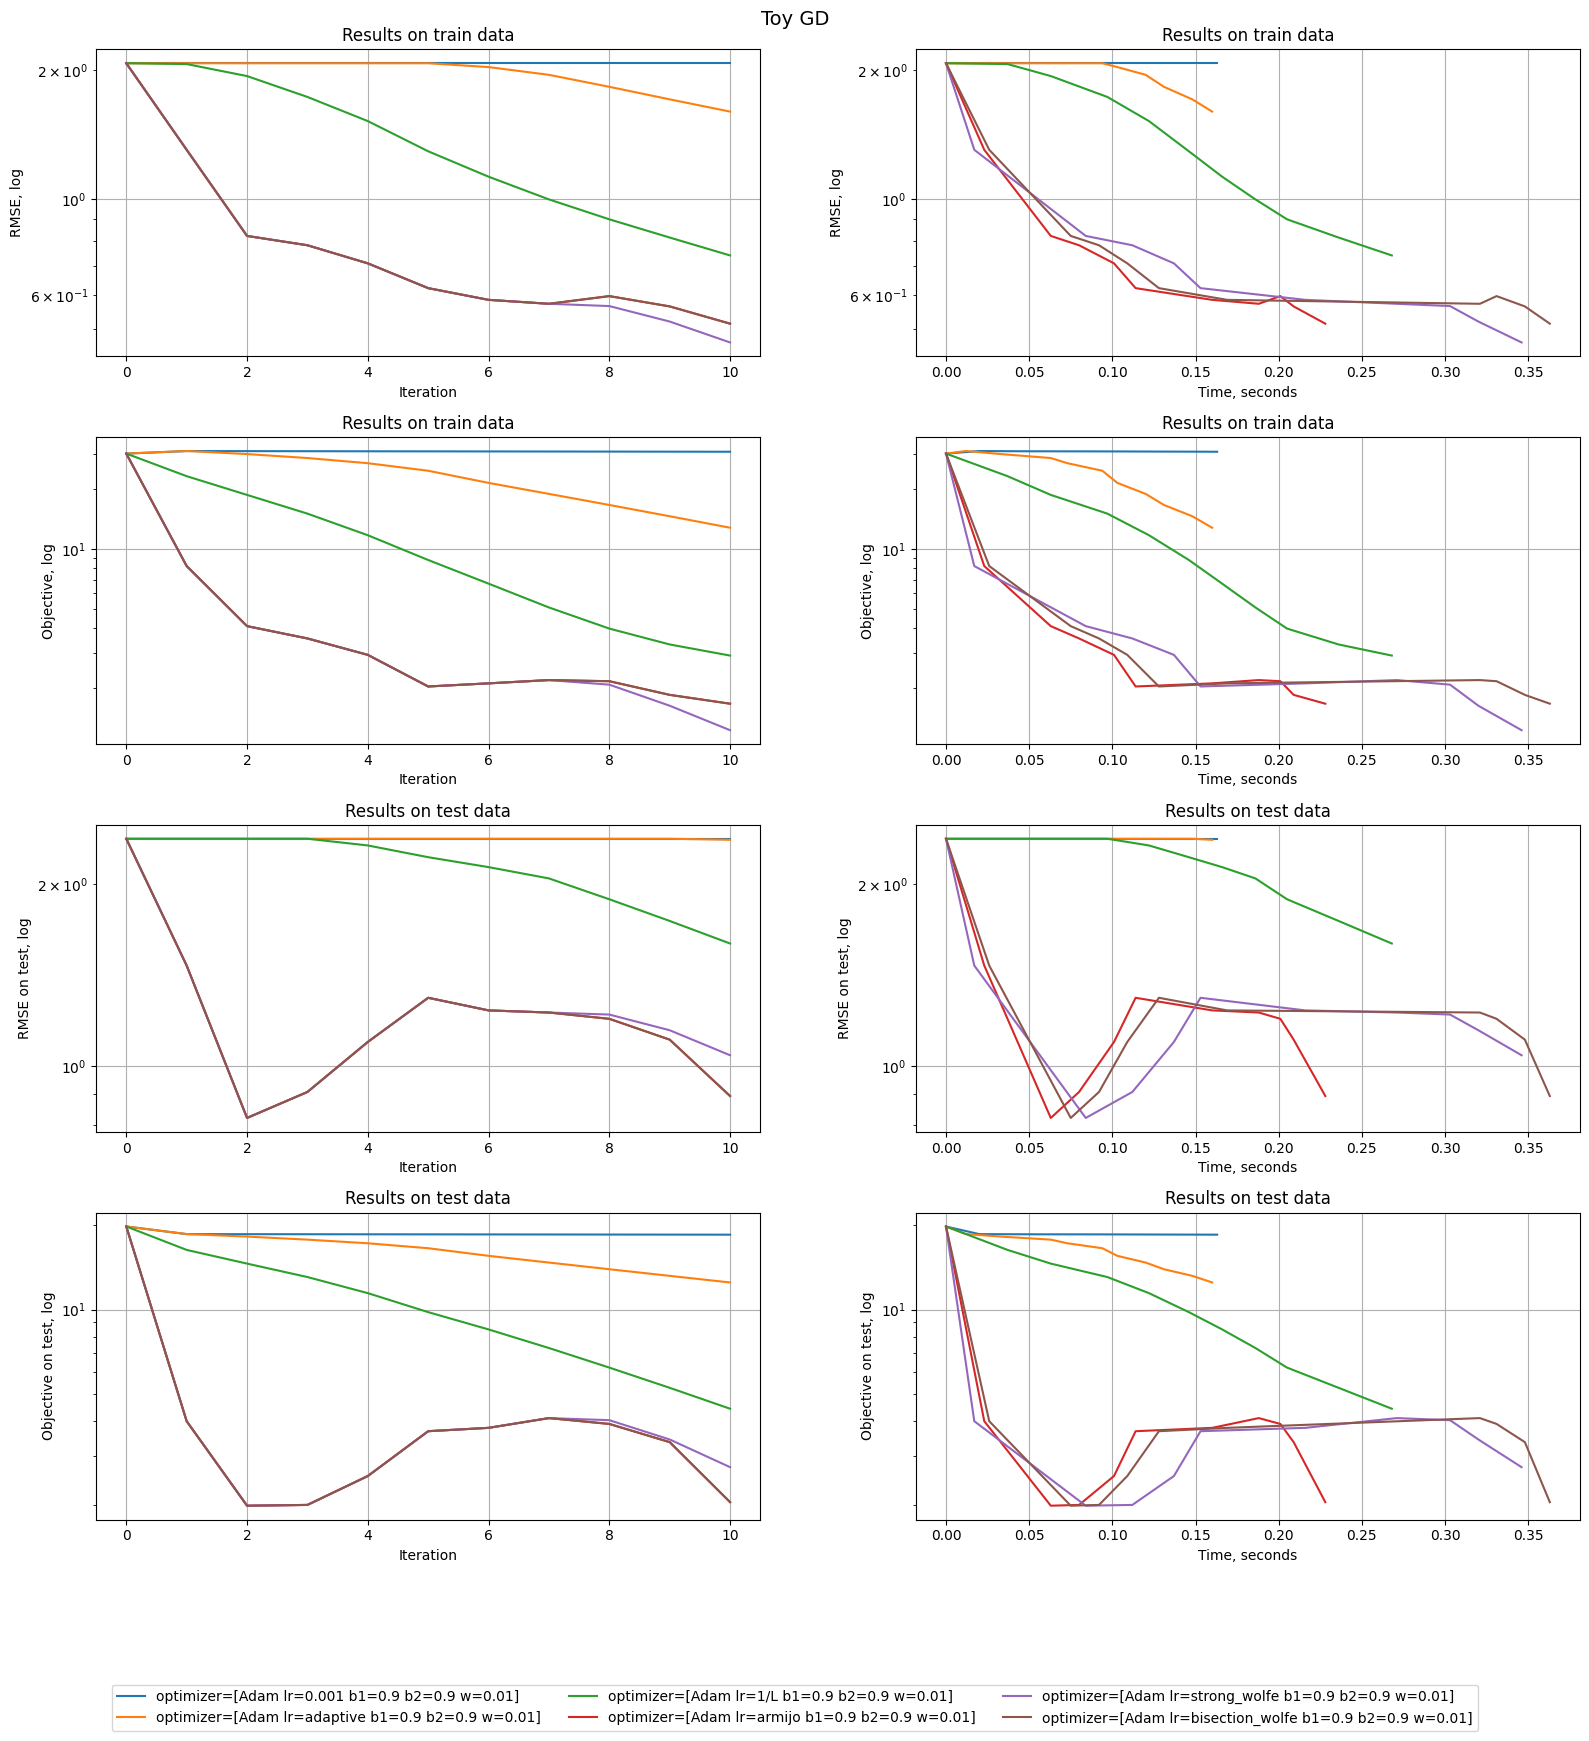

(tensor([[2.0000, 3.0000, 2.0000, 2.1232, 2.4226],
         [3.0547, 2.0000, 3.3747, 4.0000, 5.8284],
         [3.0000, 1.3454, 3.0000, 1.6551, 4.0000],
         [3.1500, 3.0000, 3.4799, 4.0000, 5.9166],
         [1.8464, 1.0000, 1.9120, 1.0000, 2.0000],
         [1.0000, 6.5901, 3.0000, 4.0000, 2.5776]], device='cuda:0'),
 0.8214222192764282,
 2,
 0.0629873275756836,
 'optimizer=[Adam lr=armijo b1=0.9 b2=0.9 w=0.01]')

In [443]:
gd_toy_res = choose_best(
    toy_matrix_full,
    toy_mask,
    toy_test_mask,
    pure_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "sgd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                Adam(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-3),
                    AdaptiveStep(),
                    Estimate1OverL(),
                    Armijo(),
                    StrongWolfe(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0.1,
        "clip": True,
        "verbose": True,
    },
)

plot_log_dicts(gd_toy_res[-1], "Toy GD")

gd_toy_res[:-1]

100%|██████████| 25/25 [00:08<00:00,  3.07it/s, Objective=1.37e+3, RMSE=0.94, Objective[test]=745, RMSE[test]=0.98]    


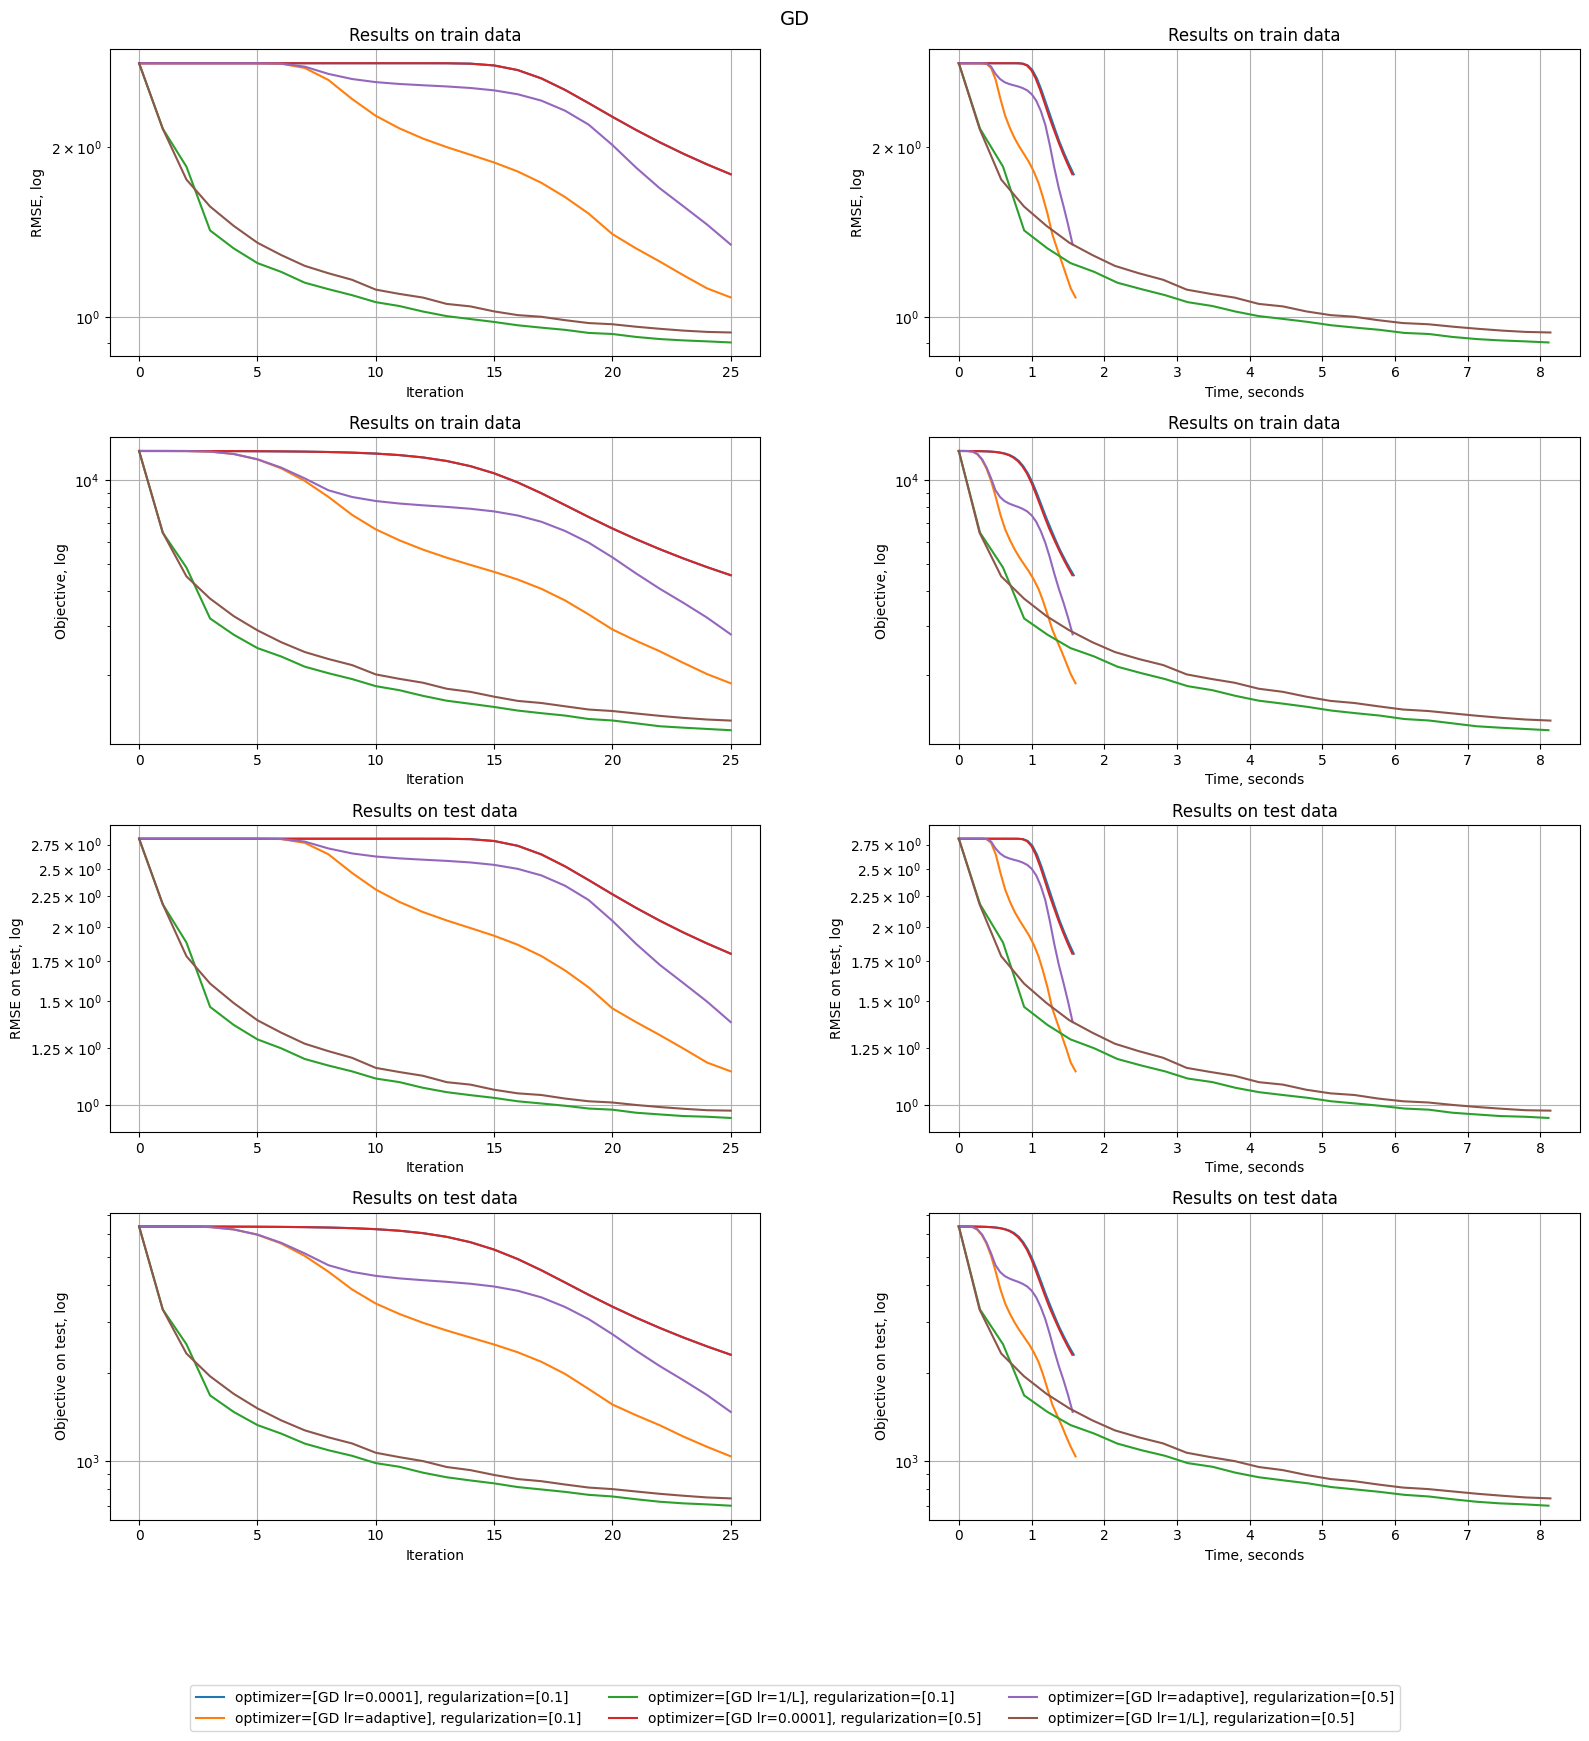

(tensor([[5.0000, 3.2106, 2.7248,  ..., 1.7788, 1.4131, 3.1168],
         [3.8489, 2.8403, 2.6986,  ..., 2.1458, 1.6330, 3.7232],
         [4.0596, 2.9360, 2.8211,  ..., 1.9367, 1.4098, 3.5030],
         ...,
         [3.0628, 1.9934, 1.8784,  ..., 1.4895, 1.1821, 2.5306],
         [4.1260, 2.7559, 2.3069,  ..., 2.0787, 1.7225, 3.1345],
         [3.0000, 1.7659, 1.5726,  ..., 2.5655, 2.3559, 3.5109]],
        device='cuda:0'),
 0.9523747563362122,
 25,
 8.11135983467102,
 'optimizer=[GD lr=1/L], regularization=[0.1]')

In [243]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 25,
        "init_strategy": "svd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                GradientDescent(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-4),
                    AdaptiveStep(),
                    Estimate1OverL(),
                    # Armijo(),
                    # StrongWolfe(),
                    # BisectionWolfe(),
                ]
            ]
        ],
        "regularization": [0.1, 0.5],
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

100%|██████████| 25/25 [00:05<00:00,  4.19it/s, Objective=7.36e+3, RMSE=2.18, Objective[test]=4.21e+3, RMSE[test]=2.26]


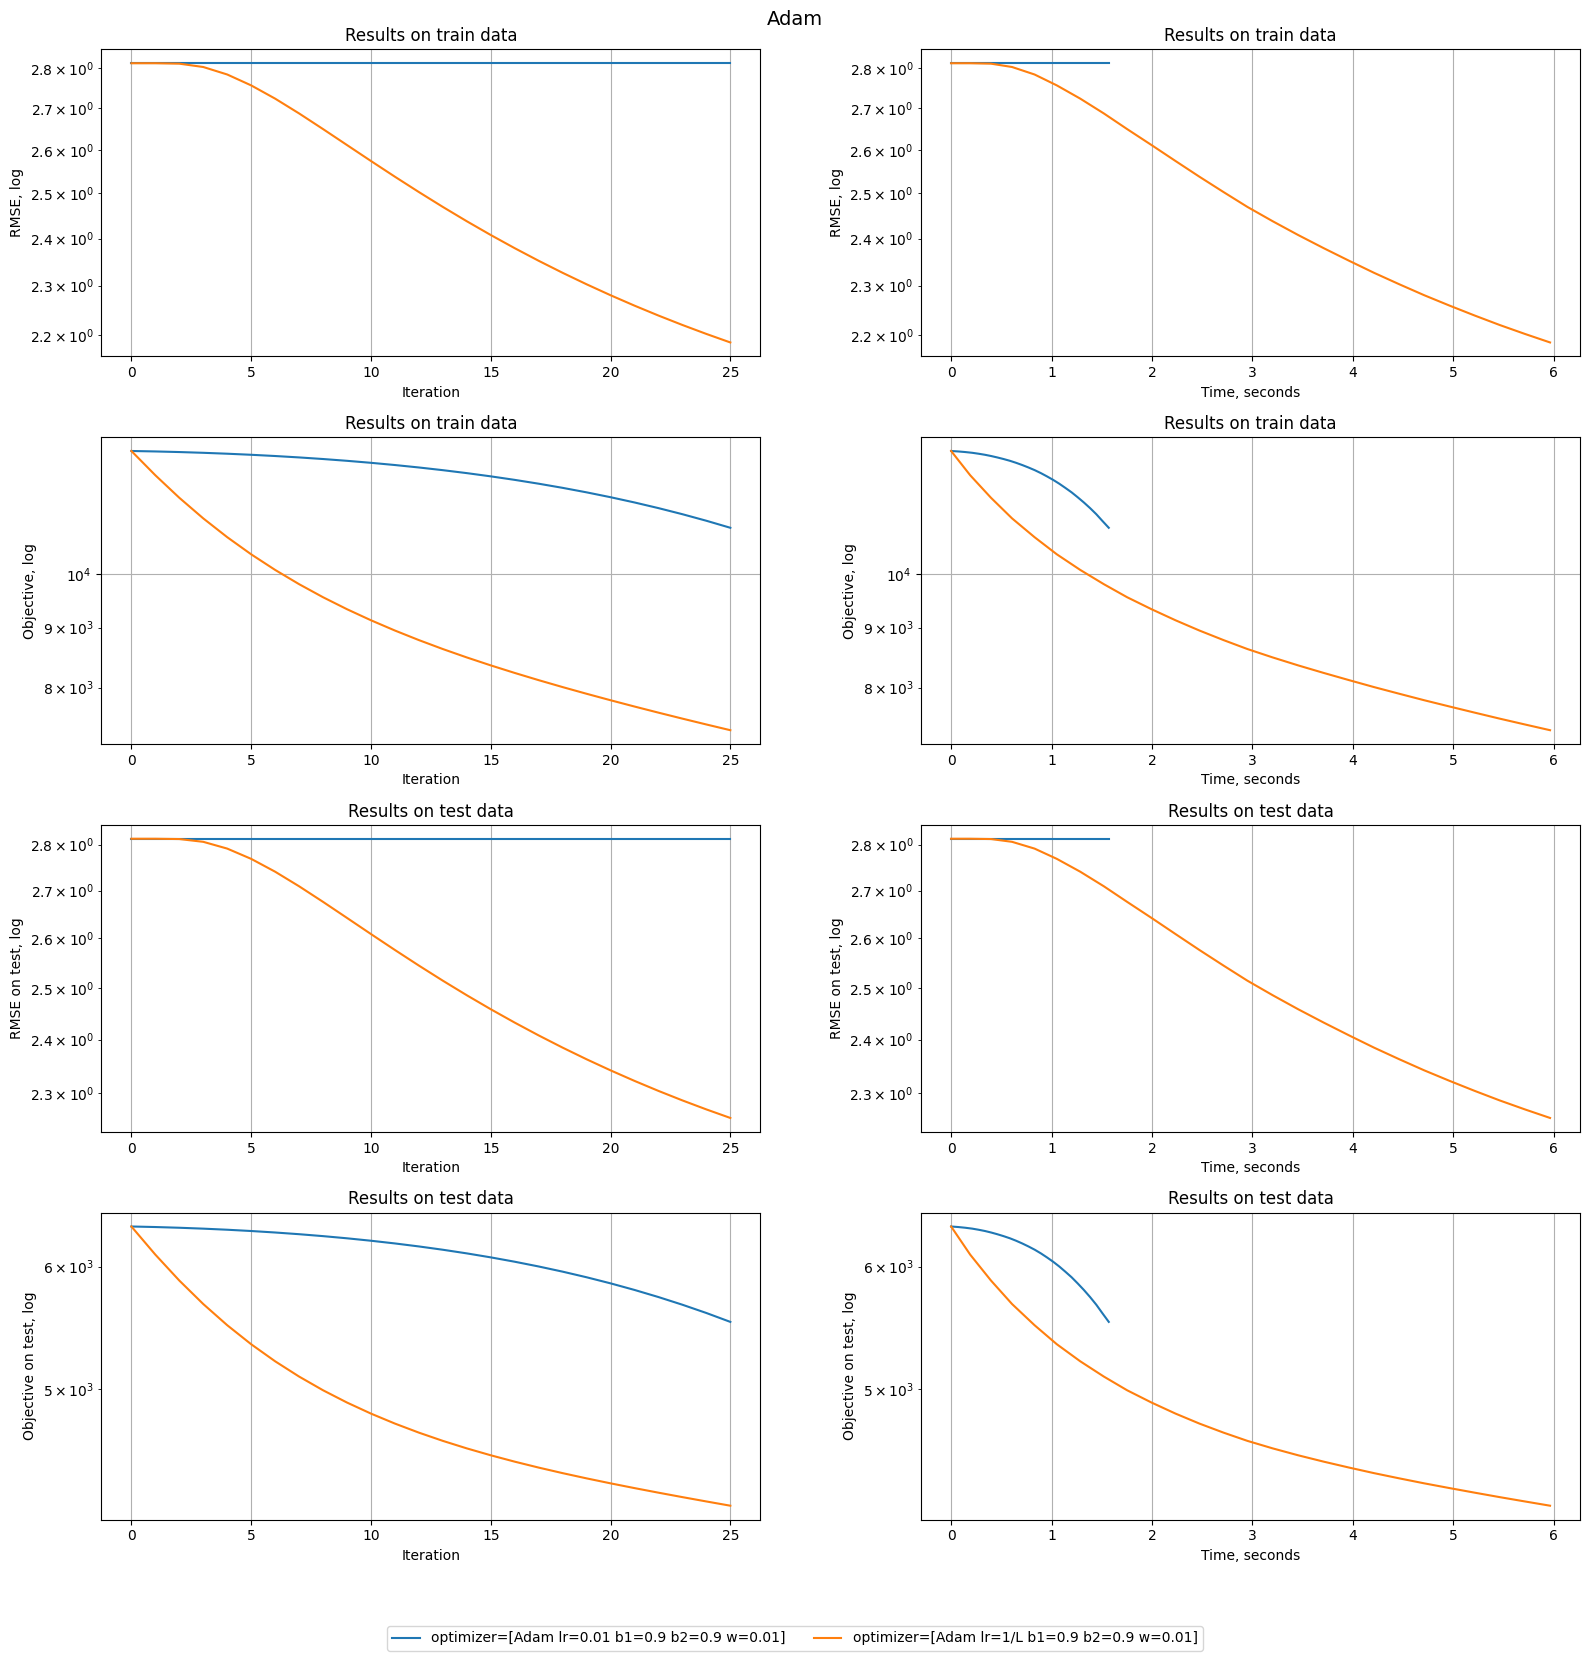

(tensor([[5.0000, 2.0094, 1.4396,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.2875],
         [5.0000, 1.0000, 1.1265,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [3.4459, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [5.0000, 1.8600, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [3.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        device='cuda:0'),
 2.255729913711548,
 25,
 5.965035438537598,
 'optimizer=[Adam lr=1/L b1=0.9 b2=0.9 w=0.01]')

In [250]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 25,
        "init_strategy": "svg",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                Adam(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-2),
                    # AdaptiveStep(),
                    Estimate1OverL(),
                    # Armijo(),
                    # BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "Adam")

gd_res[:-1]

100%|██████████| 150/150 [00:27<00:00,  5.47it/s, Objective=774, RMSE=0.712, Objective[test]=773, RMSE[test]=0.917]    


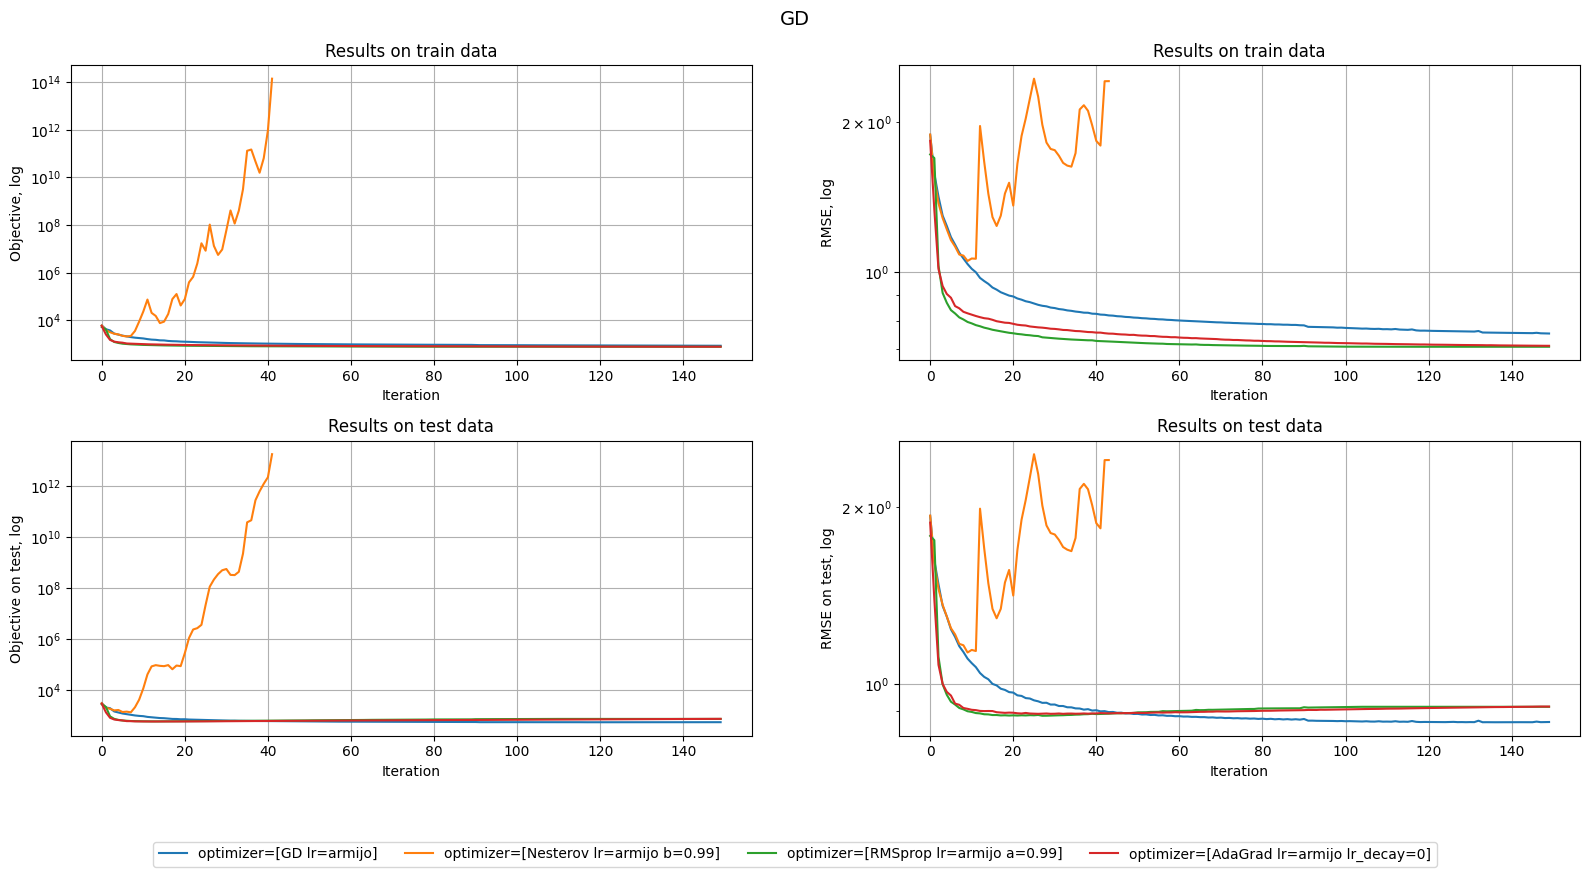

(tensor([[5.0000, 3.2156, 3.4946,  ..., 3.1942, 3.1258, 3.5128],
         [4.3858, 3.0924, 3.5639,  ..., 3.4255, 3.1114, 3.9292],
         [4.0895, 3.3185, 3.9818,  ..., 3.2501, 2.5168, 3.8914],
         ...,
         [3.6401, 2.6101, 2.3763,  ..., 3.0742, 3.2270, 3.7263],
         [3.8382, 2.7136, 2.4733,  ..., 3.1719, 3.4207, 3.4522],
         [3.0000, 1.6935, 1.0000,  ..., 3.2796, 4.6147, 3.5903]],
        device='cuda:0'),
 0.8632461428642273,
 {'rank': 12,
  'iterations': 150,
  'init_strategy': 'mean',
  'optimizer': <__main__.GradientDescent at 0x24a8031a3c0>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 12,
        "iterations": 150,
        "init_strategy": "mean",
        "optimizer": [
            GradientDescent(lr_scheduler=Armijo()),
            # Nesterov(lr_scheduler=Armijo()),
            RMSprop(lr_scheduler=Armijo()),
            AdaGrad(lr_scheduler=Armijo()),
        ],
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

100%|██████████| 200/200 [01:12<00:00,  2.75it/s, Objective=826, RMSE=0.743, Objective[test]=579, RMSE[test]=0.866]     


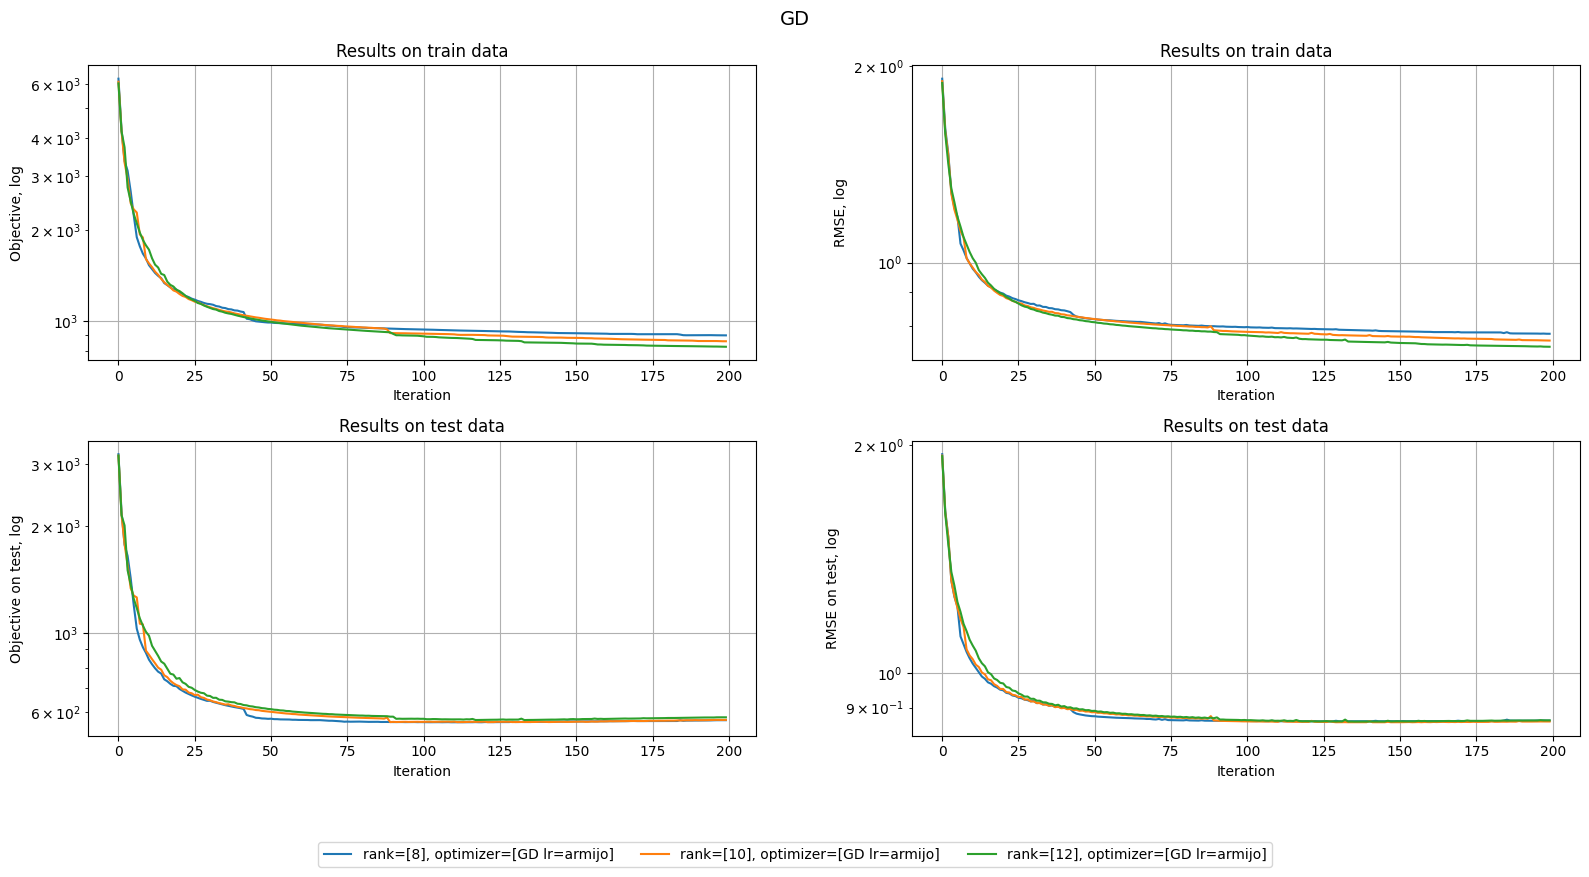

(tensor([[5.0000, 3.1853, 3.2916,  ..., 3.4073, 3.3703, 3.5075],
         [4.2693, 3.1630, 3.4337,  ..., 3.5896, 3.2232, 3.9115],
         [3.7414, 3.2820, 3.6726,  ..., 3.5600, 2.7664, 3.9841],
         ...,
         [3.5413, 2.7014, 2.6005,  ..., 3.3164, 3.5200, 4.0624],
         [3.7932, 2.6217, 2.2867,  ..., 3.3836, 3.7363, 3.7197],
         [3.0000, 1.4178, 1.0000,  ..., 3.1709, 4.6684, 3.6990]],
        device='cuda:0'),
 0.8626747727394104,
 {'rank': 10,
  'iterations': 200,
  'init_strategy': 'mean',
  'optimizer': <__main__.GradientDescent at 0x24a4a7e9e80>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": [8, 10, 12],
        "iterations": 200,
        "init_strategy": "mean",
        "optimizer": [
            GradientDescent(lr_scheduler=Armijo()),
        ],
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

In [ ]:
# save_solution(gd_res[0], decimals=5, prefix="gd10_")

100%|██████████| 420/420 [00:32<00:00, 12.97it/s, Objective=658, RMSE=0.646, Objective[test]=508, RMSE[test]=0.82]        


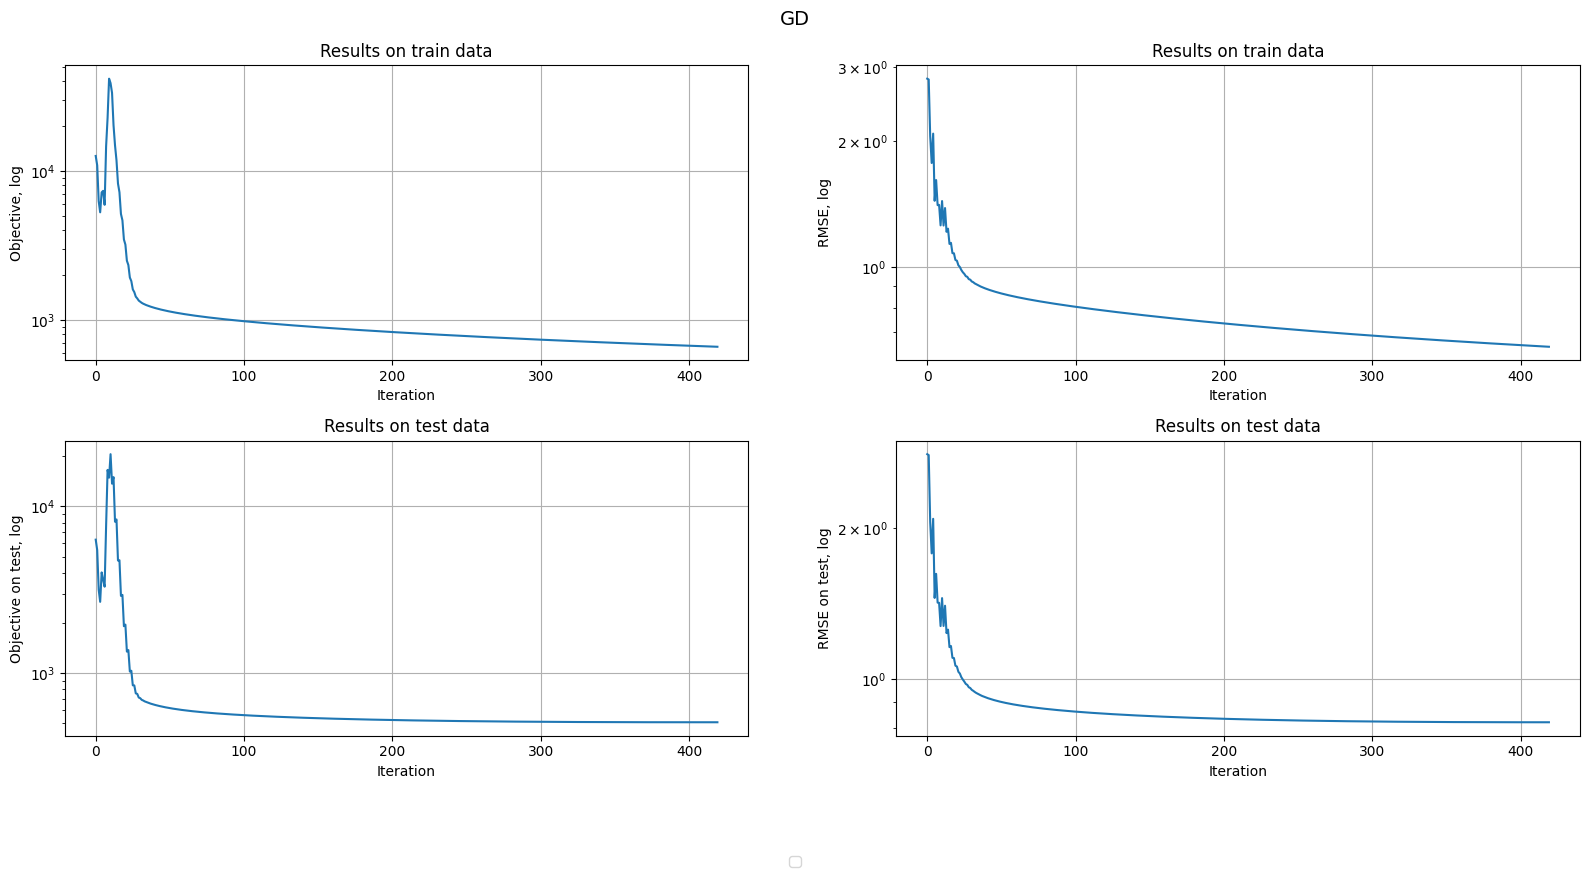

(tensor([[5.0000, 3.4933, 3.2227,  ..., 3.7155, 4.0858, 3.9562],
         [4.0802, 3.3811, 3.1074,  ..., 3.4501, 3.7138, 3.8275],
         [4.4936, 3.5336, 3.4363,  ..., 3.5713, 3.7853, 3.8369],
         ...,
         [4.0340, 3.0216, 2.6836,  ..., 3.3943, 3.7519, 3.7268],
         [4.3038, 2.9841, 2.8805,  ..., 3.5141, 3.9046, 3.7214],
         [3.0000, 1.8968, 1.6157,  ..., 3.2875, 3.9034, 3.4095]],
        device='cuda:0'),
 0.8202496767044067,
 {'rank': 80,
  'iterations': 420,
  'init_strategy': 'mean',
  'optimizer': <__main__.GradientDescent at 0x24a3e3f1340>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 80,
        "iterations": 420,
        "init_strategy": "mean",
        "optimizer": GradientDescent(
            lr_scheduler=Normal(
                lambda k: 1e-3 / np.sqrt(k),
            )
        ),
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

In [371]:
save_solution(gd_res[0], decimals=5, prefix="gd80_")

## Vector descent


In [444]:
def vector_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    rank: int | float,
    iterations: int,
    optimizer: Optimizer,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    verbose: bool = True,
    seed: int = 420,
    device: torch.device = DEVICE,
) -> dict:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    matrix = matrix.to(device)
    mask = mask.to(device)
    test_mask = test_mask.to(device)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy, device=device)
    optimizer.reset()
    optimizer.lr_scheduler.set_assume_vectors(True)  # Important!
    u_optim = optimizer
    v_optim = copy.deepcopy(optimizer)

    # Initial log
    logger = Logger(
        matrix,
        mask,
        test_mask,
        objective_gd,
        f_params={"regularization": 0},
        verbose=verbose,
    )
    logger.log(u, v, 0)

    with tqdm.tqdm(range(1, iterations + 1), disable=not verbose) as loop:
        for k in loop:
            # Optimize

            # u,u,u,v,v
            for idx in range(matrix.shape[0] + matrix.shape[1]):
                residual = idx % 5
                if residual < 3:
                    # Optimize u
                    i = 3 * (idx // 5) + residual
                    if i >= matrix.shape[0]:
                        continue
                    u[i, :] = u_optim.step(
                        u[i, :],
                        lambda x: objective_gd(
                            matrix[i, :],
                            mask[i, :],
                            x,
                            v,
                            regularization=regularization,
                        ),
                        lambda x: nabla_objective_gd(
                            matrix[i, :],
                            mask[i, :],
                            x,
                            v,
                            regularization=regularization,
                        ),
                        k,
                    )

                    if clip:
                        u = torch.clip(u, 0)

                    continue

                # Optimize v
                j = 2 * (idx // 5) + residual - 3
                if j >= matrix.shape[1]:
                    continue
                v[:, j] = v_optim.step(
                    v[:, j],
                    lambda x: objective_gd(
                        matrix[:, j],
                        mask[:, j],
                        u,
                        x,
                        regularization=regularization,
                    ),
                    lambda x: nabla_objective_gd(
                        matrix[:, j],
                        mask[:, j],
                        u,
                        x,
                        regularization=regularization,
                        for_v=True,
                    ),
                    k,
                )

                if clip:
                    v = torch.clip(v, 0)

            # log
            logger.log(u, v, k, loop=loop)

        return logger.log_dict

  0%|          | 0/10 [00:00<?, ?it/s, Objective=6.06, RMSE=0.834, Objective[test]=9.24, RMSE[test]=1.8] 

100%|██████████| 10/10 [00:00<00:00, 75.19it/s, Objective=5.27, RMSE=0.792, Objective[test]=9.39, RMSE[test]=1.75]


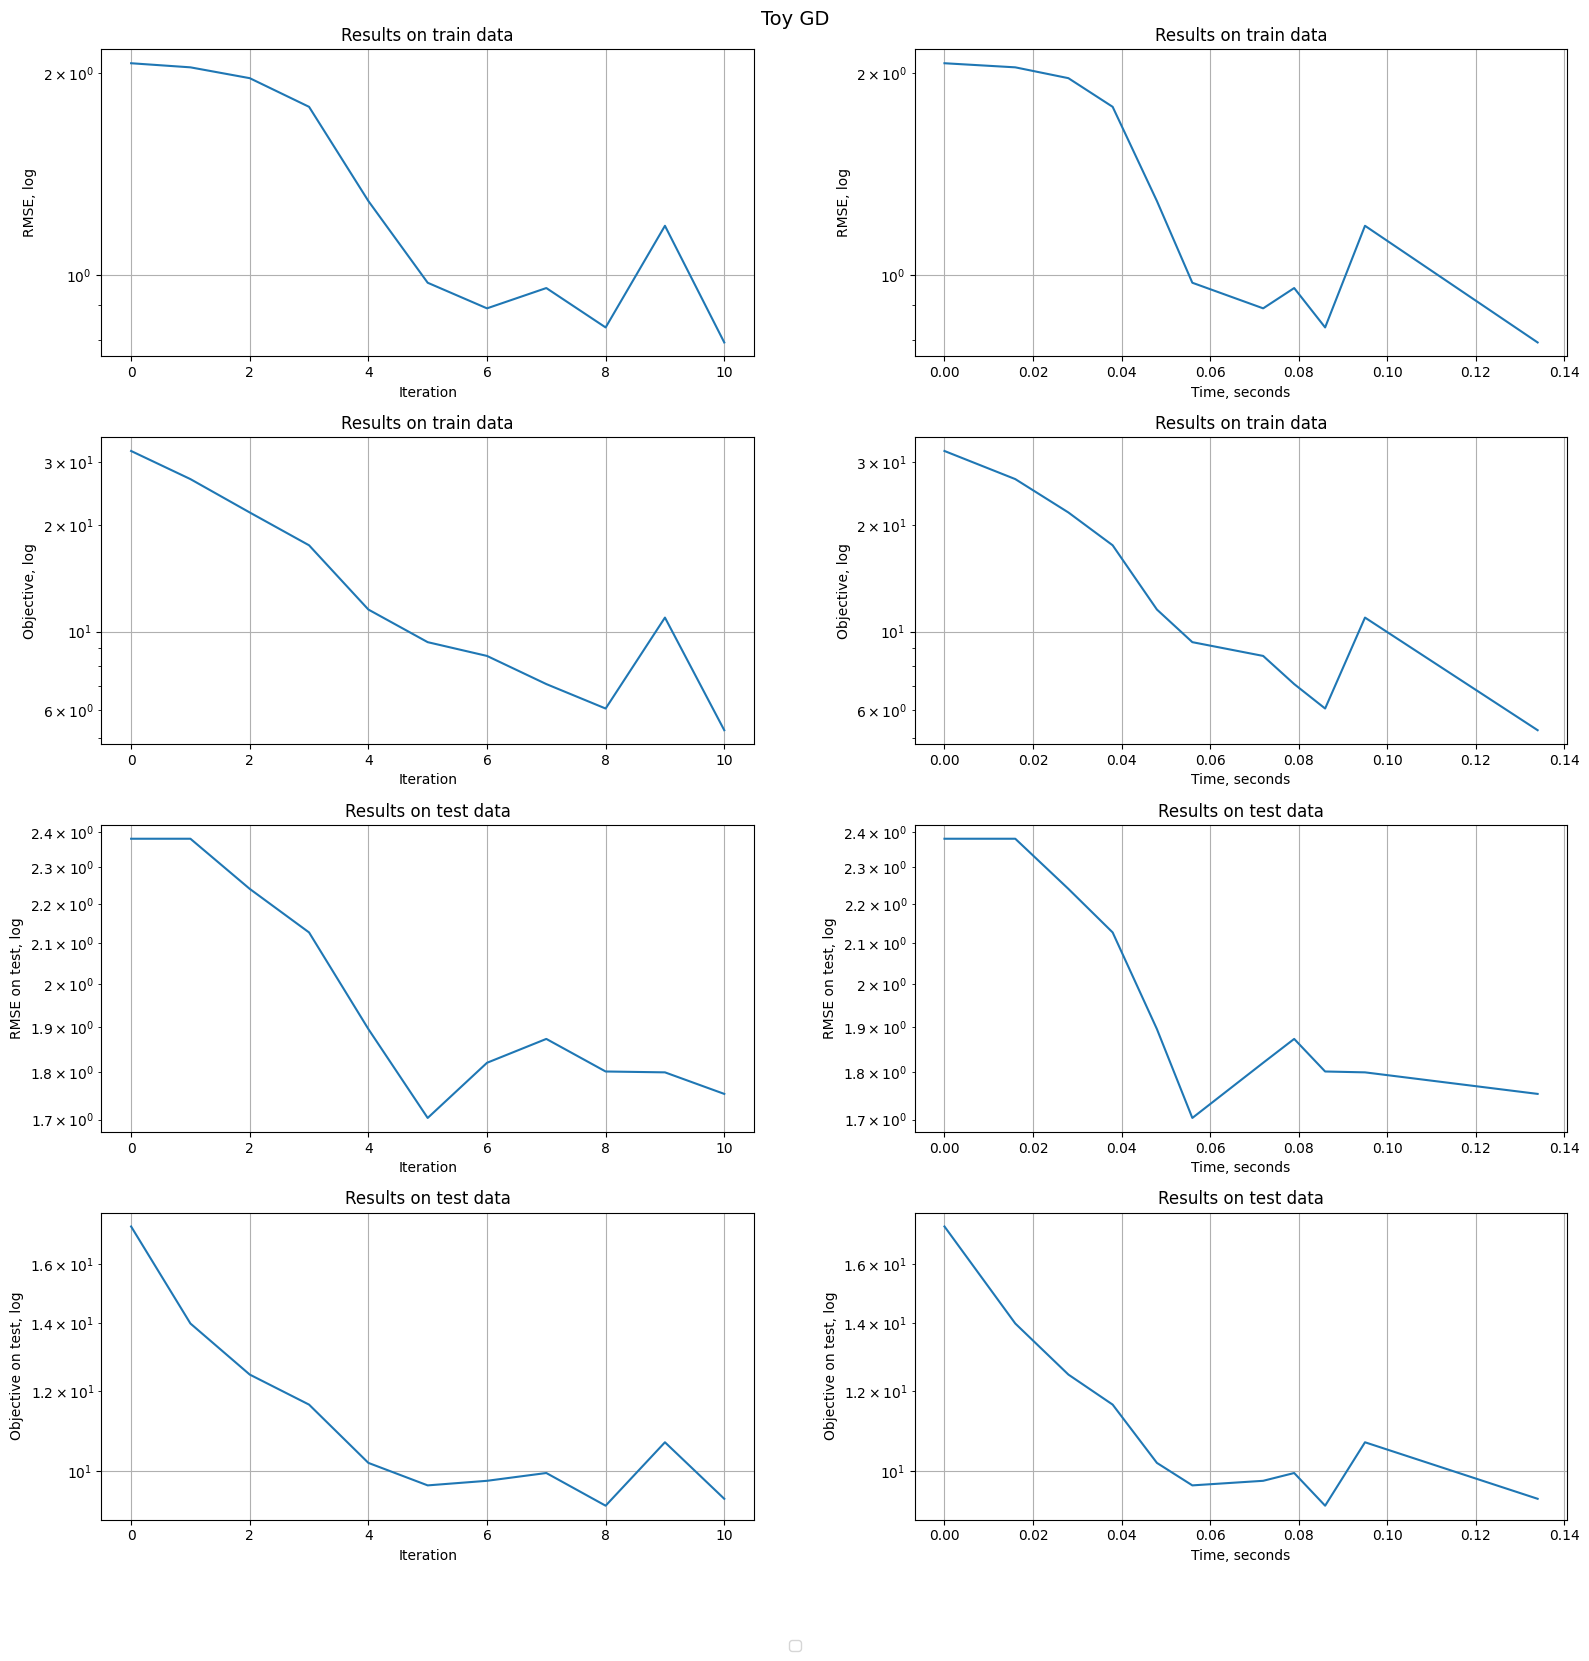

(tensor([[2.0000, 3.0000, 2.0000, 2.7562, 1.0000],
         [1.0000, 2.0000, 2.0342, 4.0000, 4.0000],
         [3.0000, 2.0329, 3.0000, 1.7600, 4.0000],
         [1.1937, 3.0000, 3.0690, 4.0000, 4.0000],
         [1.0000, 1.3317, 1.2757, 1.6912, 2.0000],
         [1.0000, 7.1617, 3.0000, 4.0000, 1.0000]], device='cuda:0'),
 1.7032089233398438,
 5,
 0.05599355697631836,
 '')

In [445]:
vector_gd_toy_res = choose_best(
    toy_matrix_full,
    toy_mask,
    toy_test_mask,
    vector_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "svd",
        "optimizer": GradientDescent(AdaptiveStep()),
        "regularization": 0.1,
        "verbose": True,
        "device": "cpu",
    },
)

plot_log_dicts(vector_gd_toy_res[-1], "Toy GD")

vector_gd_toy_res[:-1]

100%|██████████| 2/2 [00:13<00:00,  6.73s/it, Objective=9e+3, RMSE=2.61, Objective[test]=4.52e+3, RMSE[test]=2.61]   


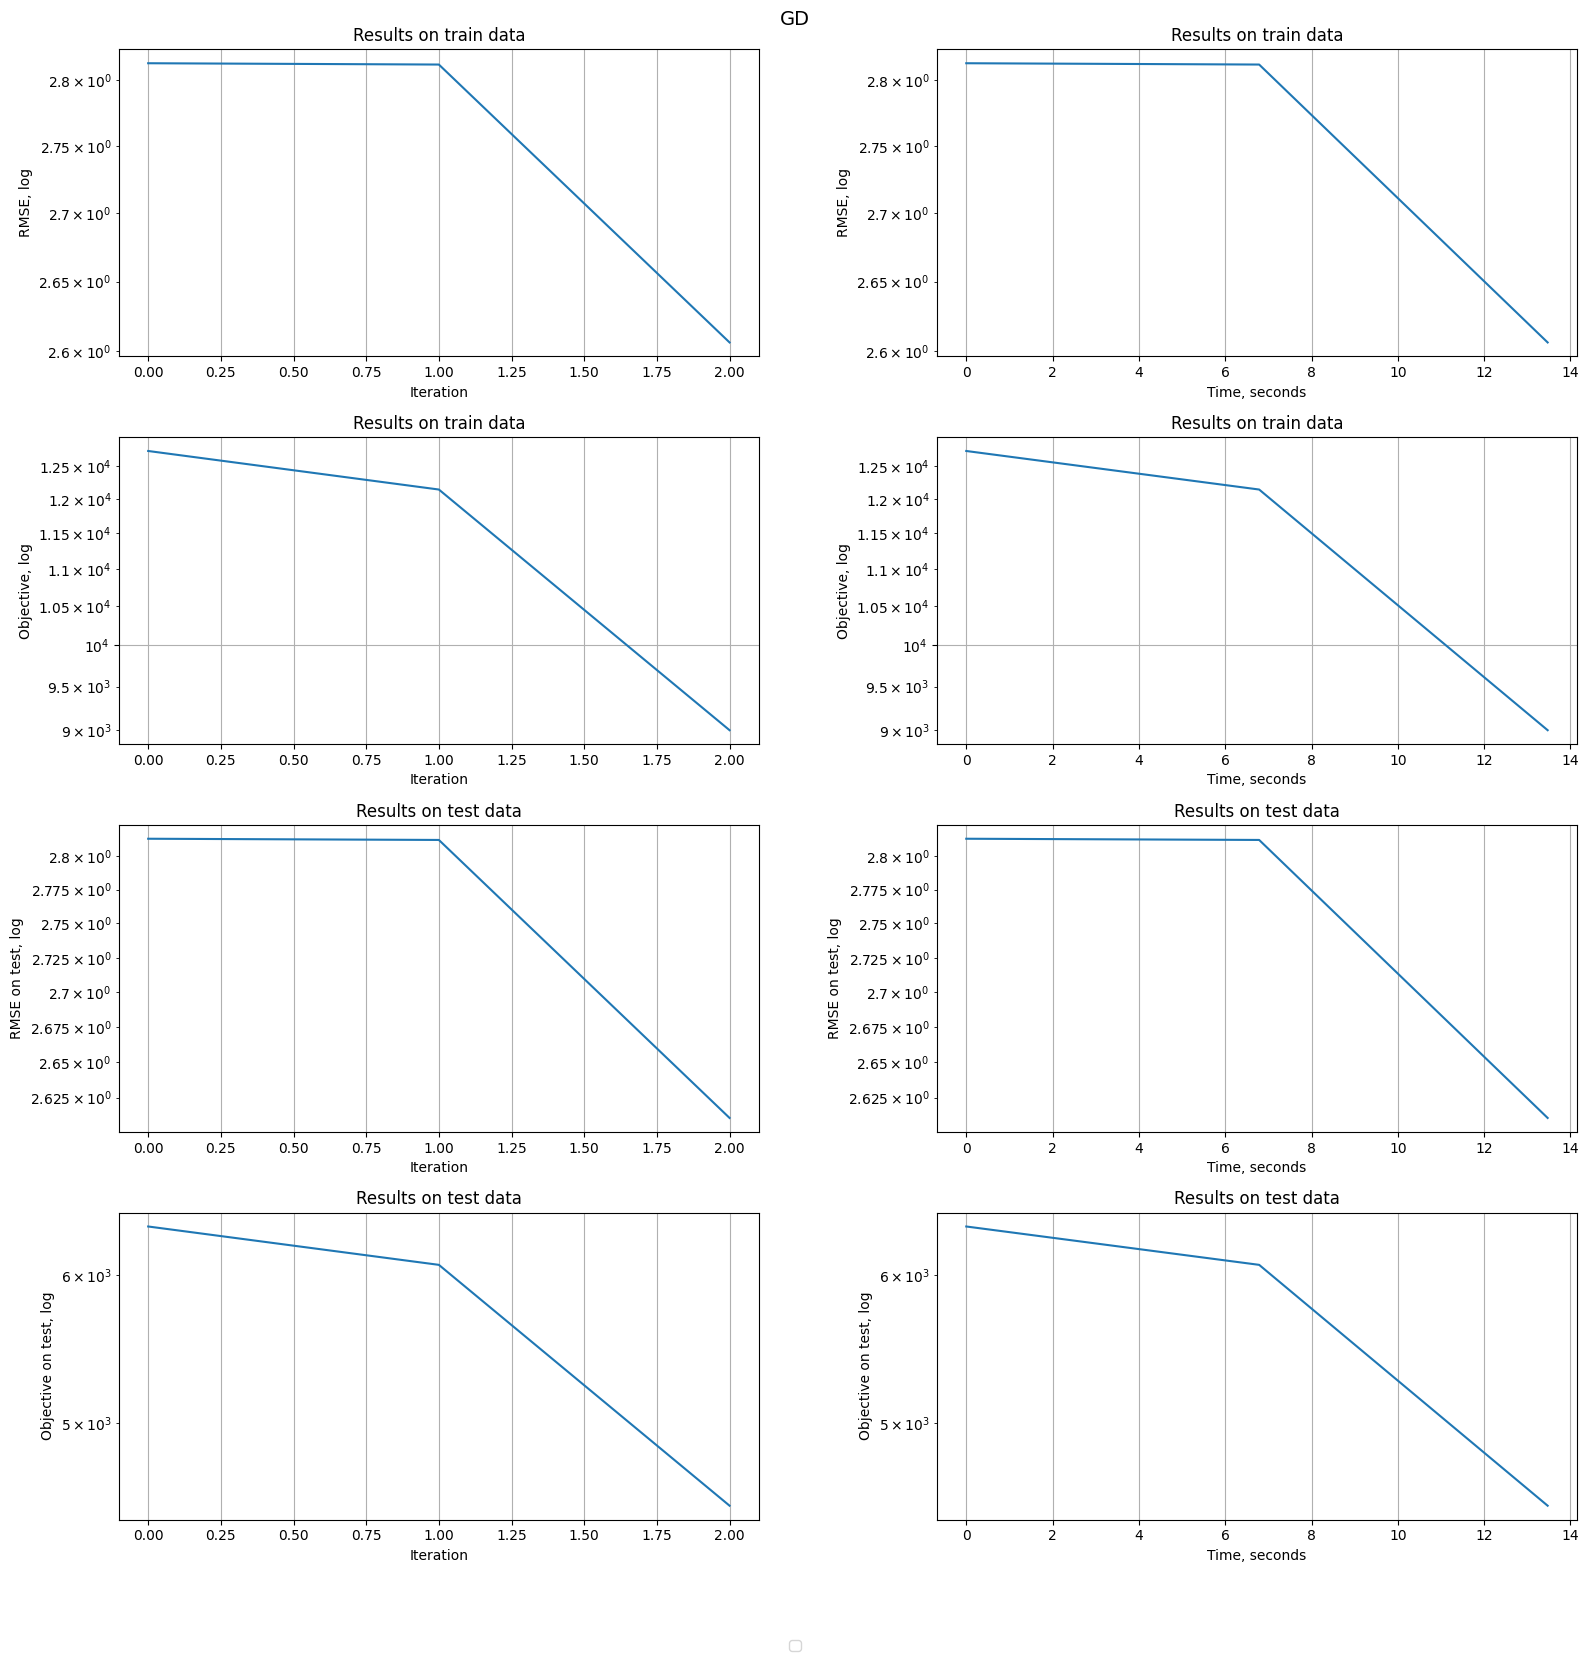

(tensor([[5., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [3., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0'),
 2.610764265060425,
 2,
 13.47192645072937,
 '')

In [449]:
vector_gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    vector_gd,
    {
        "rank": 10,
        "iterations": 2,
        "init_strategy": "svd",
        # "optimizer": BFGS(BisectionWolfe()),
        "optimizer": GradientDescent(Normal(lambda k: 1e-3 / k)),
        "regularization": 0.1,
        "clip": True,
        "verbose": True,
        "device": "cpu",
    },
)

plot_log_dicts(vector_gd_res[-1], "GD")

vector_gd_res[:-1]

## Heuristic


In [ ]:
# def clamp_to_mean(
#     result: torch.Tensor, matrix: torch.Tensor, mask: torch.Tensor
# ) -> torch.Tensor:
#     x = result.clone()

#     means = torch.sum(matrix, axis=0) / torch.sum(mask, axis=0)

#     for j, m in zip(range(x.shape[1]), means):
#         lower = torch.where(x[:, j] > m)[0]
#         upper = torch.where(x[:, j] <= m)[0]
#         x[lower, j] = torch.floor(x[lower, j]).float()
#         x[upper, j] = torch.ceil(x[upper, j]).float()

#     return matrix + (~mask) * x



In [257]:
# mean_res = clamp_to_mean(gd_res[0], real_matrix, real_mask)

In [258]:
# save_solution(mean_res, decimals=0, prefix="gdeur")

In [259]:
# save_solution(torch.round(gd_res[0]), decimals=0, prefix="gderound")